In [1]:
import pandas as pd

from bokeh.io import output_notebook, show
from bokeh.plotting import figure

import numpy as np
from scipy import signal

output_notebook()

%matplotlib inline


Loading BokehJS ...

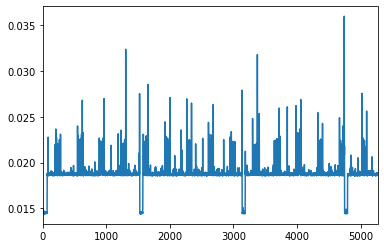

In [9]:
df = pd.read_csv('test01.txt', sep=' ', names=['t', 'x', 'y', 'z'])
df.t.diff().plot()


In [11]:
# in the first tests the samplig was not homogeneous
df.x = np.interp(np.linspace(df.t.min(), df.t.max(), len(df.t) ), df.t, df.x)
df.y = np.interp(np.linspace(df.t.min(), df.t.max(), len(df.t) ), df.t, df.y)
df.z = np.interp(np.linspace(df.t.min(), df.t.max(), len(df.t) ), df.t, df.z)

In [13]:
sel = df.x

p = figure(plot_width=800, plot_height=400)
p.line(np.linspace(0, len(df.x)*0.01, len(df.x)), (2/(2**20))*sel, line_width=2, line_color='red', legend="000")
show(p)


f, Pxx = signal.welch(sel, 100, nperseg=512, scaling="spectrum")
p = figure(plot_width=800, plot_height=400, y_axis_type="log", x_axis_type="log")
p.line(f, np.sqrt(Pxx), line_width=2, line_color='red', legend="000")
show(p)

### 